In [20]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from analysis import Analysis

avila = Analysis('avila_spain', [40.62743561185206, -4.737151721737033, 40.67607507964895, -4.647455953449498], pois_shp_path="cities/avila_spain/full_uses.shp")

In [43]:
avila.pois

Querying locally for `['pois']`
Found ['pois'] stored locally


,category,key,lat,lon,value
id,,,,,
325315918,activity,leisure,40.629154,-4.648201,pitch
325315920,activity,leisure,40.629008,-4.647757,pitch
325315921,activity,leisure,40.628869,-4.647456,pitch
3544687641,activity,shop,40.641578,-4.690898,butcher
3545585660,activity,shop,40.646708,-4.684789,butcher
3561383994,activity,shop,40.648118,-4.683430,variety_store
3561328056,activity,shop,40.648091,-4.682708,florist
3534280025,activity,shop,40.648258,-4.681678,supermarket
1728989987,activity,shop,40.648089,-4.680634,video


In [46]:
avila.kde

{'activity':               0             1             2             3             4   \
 0   2.145316e-07  2.061972e-07  1.831076e-07  1.503665e-07  1.148736e-07   
 1   4.499125e-06  4.324260e-06  3.839570e-06  3.150456e-06  2.393738e-06   
 2   7.227161e-05  6.946224e-05  6.167393e-05  5.059083e-05  3.836764e-05   
 3   8.892208e-04  8.546529e-04  7.588161e-04  6.223944e-04  4.717185e-04   
 4   8.380184e-03  8.054404e-03  7.151187e-03  5.865343e-03  4.444440e-03   
 5   6.049222e-02  5.814056e-02  5.162063e-02  4.233836e-02  3.207943e-02   
 6   3.344625e-01  3.214601e-01  2.854112e-01  2.340887e-01  1.773633e-01   
 7   1.416437e+00  1.361372e+00  1.208706e+00  9.913572e-01  7.511251e-01   
 8   4.594613e+00  4.415996e+00  3.920782e+00  3.215752e+00  2.436503e+00   
 9   1.141570e+01  1.097192e+01  9.741518e+00  7.989828e+00  6.053779e+00   
 10  2.172493e+01  2.088037e+01  1.853884e+01  1.520530e+01  1.152104e+01   
 11  3.166766e+01  3.043658e+01  2.702345e+01  2.216436e+01  1.6

In [47]:
avila.moran

{'activity': 0.038814173568409029, 'residential': 0.027365985963030828}

In [48]:
avila.relative_entropy

{'activity': 0.86566660864531164, 'residential': 0.7786920332512367}

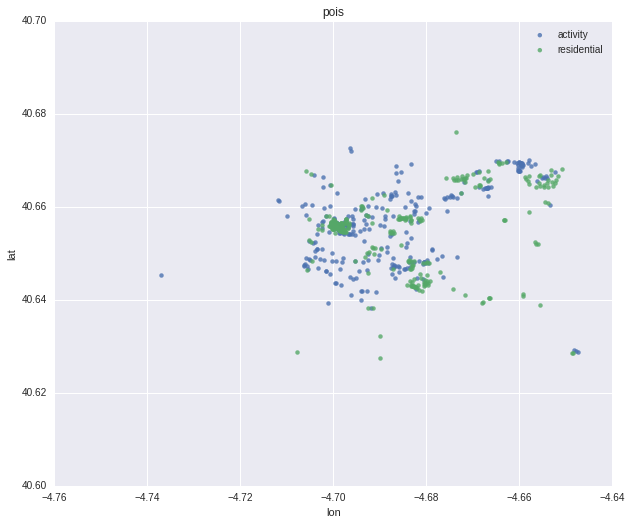

In [49]:
%matplotlib inline
avila.scatter_pois(overlap=True)